## Regional Climatology
I created a class object that is called a [Region](#object-orientation). This object has different variables and functions associated with it. It was designed with the objective of being able to quickly and flexibly complete the following tasks:

 - Mean monthly CG [flash density](#flash-density) for a region; [~ 1km grid](#Grid)
 - Mean monthly [diurnal cycle](#diurnal-cycle) of CG flash density by month for a region
 - [Largest 100](#top-100) CG flash density days (12 UTC - 12 UTC) for a region
 - [JJA time (UTC) of maximum](#peak-time) CG flash density (15 minute time resolution); ~ 1 km grid
 - [“Amplitude” of the diurnal cycle](#amplitude-of-DC); 15 minute time resolution ~1km grid.  CG flash density at the time of maximum flash density - CG flash density a time of minimum flash density divided by the mean flash density. 

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from scipy import ndimage
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn.apionly as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.img_tiles import StamenTerrain

%matplotlib inline

If you have already installed dask (in terminal: `conda install dask`) and the files are in good order, all have the same variables, and are available locally, then this will work:

    xr.open_mfdataset('<path-to-data>/Cloud_to_Ground_Lightning/US/2014_01_*.nc', concat_dim='record')

If they don't have the same variables, then we can use the preprocess keyword to get just the variables that we know are in all the datasets:

    xr.open_mfdataset('<path-to-data>/Cloud_to_Ground_Lightning/US/*_04_*.nc', 
                      concat_dim='record', preprocess=(lambda x: x[['strokes', 'amplitude']])

If you don't have them locally, then you can use list of OPeNDAP URLs instead of the wildcard notation.

In [11]:
ds = xr.open_mfdataset('/home/jsignell/erddapData/Cloud_to_Ground_Lightning/US/1993_*_*.nc', concat_dim='record')

## Grid
[Top](#Regional-Climatology) | [Region](#object-orientation) | [Grid](#Grid) | [flash density](#flash-density) | [diurnal cycle](#diurnal-cycle) | [Largest 100](#top-100) | [peak](#peak-time) | [amplitude diurnal cycle](#amplitude-of-DC)

Once we have all the settings and imports, we should grid the data. The main thing that makes lightning different from other datasets is that it is a point process, so when we grid and aggregate we want to count strikes per grid cell rather than interpolating. This is a good [example](http://stackoverflow.com/questions/11015252/countig-points-in-boxes-of-a-grid) of how we will go about doing that. The premise is that we want to count the strikes within each bin, so we can use a 2D histogram.

In [12]:
x = ds.lon.values
y = ds.lat.values

gridx = np.linspace(x.min(), x.max(), 500)
gridy = np.linspace(y.min(), y.max(), 500)

grid, _, _ = np.histogram2d(x, y, bins=[gridx, gridy])
density = grid.T

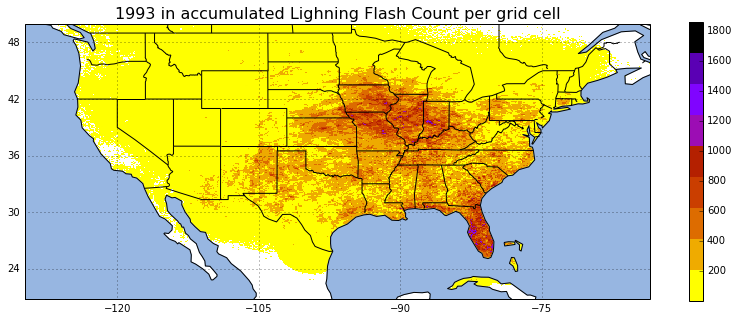

In [18]:
# define a good lightning colormap
cmap = mpl.cm.get_cmap('gnuplot_r', 9)
cmap.set_under('None')

#initiate a figure
plt.figure(figsize=(14,5))
ax = plt.axes(projection=ccrs.PlateCarree())

#add some geographic identifying features
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
states = cfeature.NaturalEarthFeature(category='cultural',
                                      name='admin_1_states_provinces_lines',
                                      scale='50m',
                                      facecolor='none')
ax.add_feature(states)
gl = ax.gridlines(draw_labels=True, zorder=4)
gl.xlabels_top = False
gl.ylabels_right = False

# draw the data over top of this template
den = ax.imshow(density, cmap=cmap, interpolation='None', vmin=1,
                extent=[gridx.min(),gridx.max(), gridy.min(), gridy.max()])
plt.title('1993 in accumulated Lighning Flash Count per grid cell', fontsize=16)
plt.colorbar(den, ax=ax);

In [19]:
ds.close()

## object orientation
[Top](#Regional-Climatology) | [Region](#object-orientation) | [Grid](#Grid) | [flash density](#flash-density) | [diurnal cycle](#diurnal-cycle) | [Largest 100](#top-100) | [peak](#peak-time) | [amplitude diurnal cycle](#amplitude-of-DC)

There are constant variables for each region so it makes sense to define a class to hold info and functions relating to the region. All the tools are generalized in the [pointprocess](http://github.com/jsignell/point-process) module

In [2]:
from pointprocess import *
from lightning_setup import *

In [3]:
c = Region(city=cities['phoenix'])
c.define_grid(nbins=600)

## flash density
[Top](#Regional-Climatology) | [Region](#object-orientation) | [Grid](#Grid) | [flash density](#flash-density) | [diurnal cycle](#diurnal-cycle) | [Largest 100](#top-100) | [peak](#peak-time) | [amplitude diurnal cycle](#amplitude-of-DC)

Once you have initiated a Region, there are a bunch of options available. 

In [4]:
MMDC_grid = {}
MMFC_grid = {}
for m in range(1,13):
    ds = c.get_ds(m=m)
    print m
    c.to_DC_grid(ds)
    ds.close()
    MMDC_grid.update({m: c.DC_grid})
    MMFC_grid.update({m: c.FC_grid})

1
2
3
4
5
6
7
8
9
10
11
12


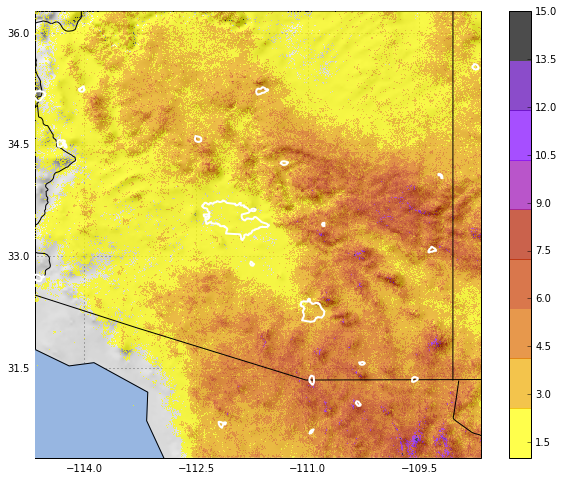

In [5]:
FC = np.sum(MMFC_grid.values(), axis=(0))

#annually averaged rate of occurrence of lightning
mean_annual_FD = FC/float(2016-1991)

plt.figure(figsize=(10,8))
im, ax = c.plot_grid(mean_annual_FD, cmap=cmap, cbar=True, zorder=5, vmin=1, vmax=15, alpha=.7)
pre_shaded(ax, fname='/home/jsignell/data/SR_50M/SR_50M.tif')
urban(ax, edgecolor='white', linewidth=2)
ax.set_extent([c.gridx.min(), c.gridx.max(), c.gridy.min(), c.gridy.max()])

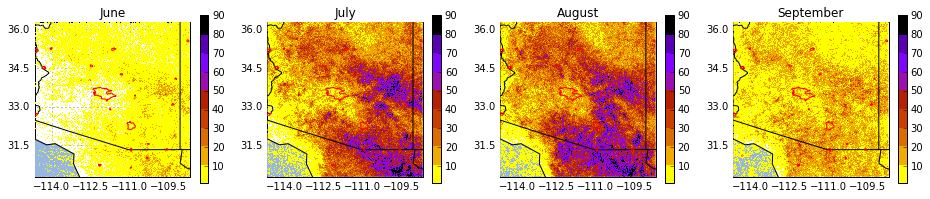

In [7]:
plt.figure(figsize=(16, 3))
n=1
for m in [6,7,8,9]:
    ax = background(plt.subplot(1, 4, n, projection=ccrs.PlateCarree()))
    ax = urban(ax)
    c.plot_grid(MMFC_grid[m], cmap=cmap, vmin=1, vmax=90, cbar=True, ax=ax, zorder=5)
    ax.set_title(months[m])
    n+=1

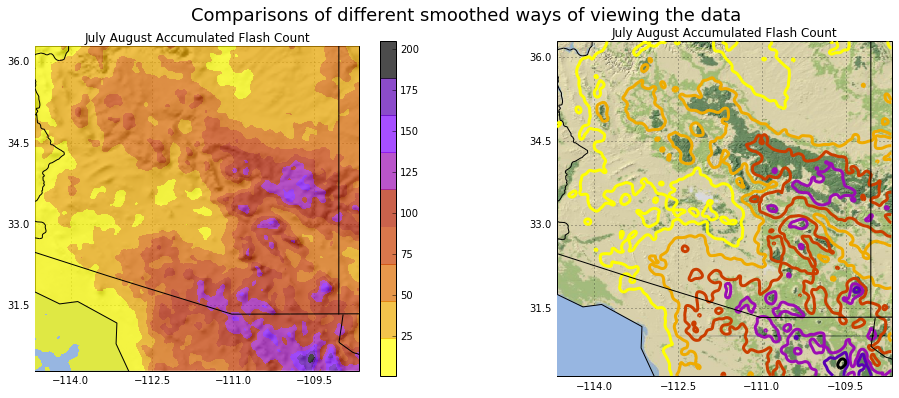

In [10]:
JAFC_grid = MMFC_grid[7]+MMFC_grid[8]
img = ndimage.gaussian_filter(JAFC_grid, 4)

plt.figure(figsize=(16,6))

ax = background(plt.subplot(1, 2, 1, projection=ccrs.PlateCarree()))
im, ax = c.plot_grid(img, cmap=cmap, cbar=True, zorder=5, alpha=.7, vmin=1, ax=ax)
pre_shaded(ax, fname='/home/jsignell/data/SR_50M/SR_50M.tif')
ax.set_extent([c.gridx.min(), c.gridx.max(), c.gridy.min(), c.gridy.max()])
ax.set_title('July August Accumulated Flash Count')

ax = background(plt.subplot(1, 2, 2,projection=ccrs.PlateCarree()))
ax.set_extent([c.gridx.min(), c.gridx.max(), c.gridy.min(), c.gridy.max()])
ax.add_image(StamenTerrain(), 7)
ax.contour(c.gridx[:-1], c.gridy[:-1], img, cmap=cmap, zorder=5, linewidths=3)
ax.set_title('July August Accumulated Flash Count')

plt.suptitle('Comparisons of different smoothed ways of viewing the data', fontsize=18)

## diurnal cycle
[Top](#Regional-Climatology) | [Region](#object-orientation) | [Grid](#Grid) | [flash density](#flash-density) | [diurnal cycle](#diurnal-cycle) | [Largest 100](#top-100) | [peak](#peak-time) | [amplitude diurnal cycle](#amplitude-of-DC)

For now this is all based around hour of the day. This is much simpler than trying to divide the day into 15min intervals. But if we decide that we really need that capability, then we can work on it.

In [11]:
h = range(12,24)
h.extend(range(0,13))

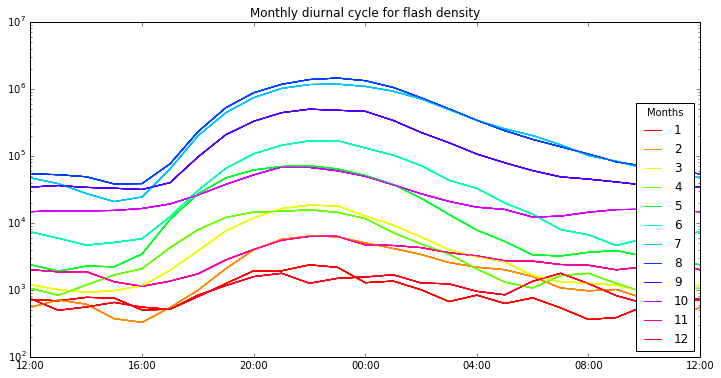

In [12]:
import matplotlib.cm as cm
h = range(12,24)
h.extend(range(0,13))

MMDC = pd.DataFrame(np.array([[np.sum(MMDC_grid[m][hr]) for hr in h] for m in months.keys()]).T)
MMDC.columns = range(1,13)

plt.figure(figsize=(12, 6))
for m in months.keys():
    ax = plt.subplot(1,1,1)
    MMDC.plot(color=cm.hsv(np.linspace(0, 1, 12)), ax=ax, title='Monthly diurnal cycle for flash density')
    plt.legend(range(1,13), title='Months', loc='lower right')
    ax.set_xticks(range(0,25,4))
    ax.set_xticklabels(['{num:02d}:00'.format(num=h[n]) for n in range(0,25,4)])
    ax.set_ylim(10**2, 10**7)
    ax.semilogy()
    ax.set_xlim(0,24)

## peak time
[Top](#Regional-Climatology) | [Region](#object-orientation) | [Grid](#Grid) | [flash density](#flash-density) | [diurnal cycle](#diurnal-cycle) | [Largest 100](#top-100) | [peak](#peak-time) | [amplitude diurnal cycle](#amplitude-of-DC)

JJA CG flash density (Hour time resolution); ~ 10 km grid


In [24]:
JADC_grid = {}
for k,v in MMDC_grid[7].items():
    JADC_grid.update({k: v + MMDC_grid[8][k]})

In [36]:
JADC_gauss = {}
for k,v in JADC_grid.items():
    JADC_gauss.update({k:ndimage.filters.gaussian_filter(v, 4)})

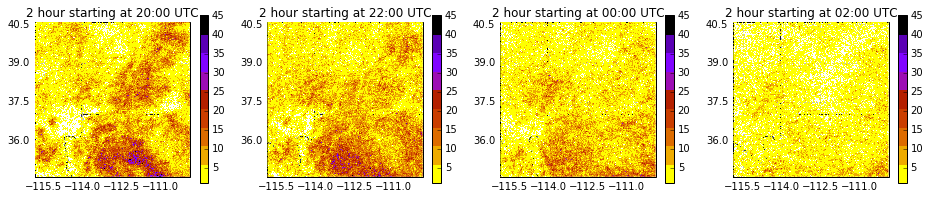

In [27]:
plt.figure(figsize=(16,3))
n=1
step = 2
for i in range(8,16,step):
    q=np.zeros(JADC_grid[0].shape)
    for hr in h[i:i+step]:
        q+=JADC_grid[hr]
    ax = background(plt.subplot(1, 4, n, projection=ccrs.PlateCarree()))
    ax.set_title('{step} hour starting at {t:02d}:00 UTC'.format(step=step, t=h[i]))
    c.plot_grid(q,cmap=cmap, vmin=1, vmax=45, cbar=True, ax=ax, zorder=10)
    n+=1

To plot the hour of peak, we need a circular colormap

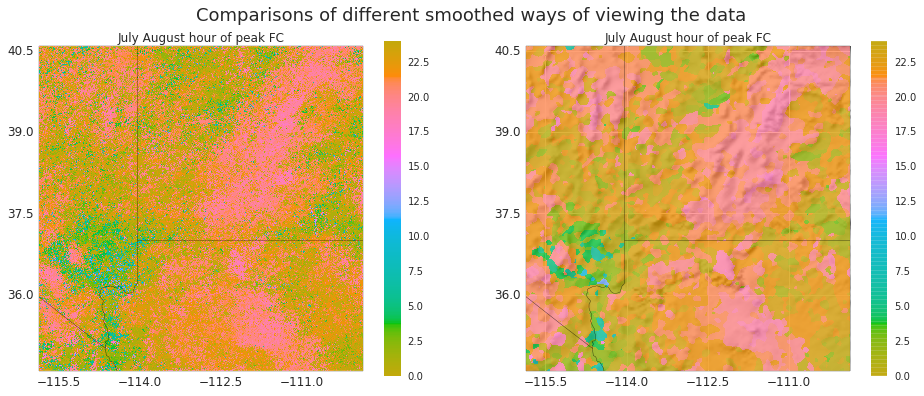

In [47]:
plt.figure(figsize=(16,6))

cmap_husl = mpl.colors.ListedColormap(sns.husl_palette(256, .2, l=.7, s=1))
img = np.argmax(np.stack(JADC_gauss.values()), axis=0)
a = np.argmax(np.stack(JADC_grid.values()), axis=0)

ax = background(plt.subplot(1, 2, 1, projection=ccrs.PlateCarree()))
im, ax = c.plot_grid(a, cmap=cmap_husl, vmin=0, vmax=24, cbar=True, ax=ax, zorder=5)
ax.set_extent([c.gridx.min(), c.gridx.max(), c.gridy.min(), c.gridy.max()])
ax.set_title('July August hour of peak FC')

ax = background(plt.subplot(1, 2, 2, projection=ccrs.PlateCarree()))
im, ax = c.plot_grid(img, cmap=cmap_husl, vmin=0, vmax=24, cbar=True, alpha=.8, ax=ax, zorder=5)
pre_shaded(ax)
ax.set_extent([c.gridx.min(), c.gridx.max(), c.gridy.min(), c.gridy.max()])
ax.set_title('July August hour of peak FC')

plt.suptitle('Comparisons of different smoothed ways of viewing the data', fontsize=18)
plt.savefig('output/cedar/JA hour of peak FC.png')

## amplitude of DC
[Top](#Regional-Climatology) | [Region](#object-orientation) | [Grid](#Grid) | [flash density](#flash-density) | [diurnal cycle](#diurnal-cycle) | [Largest 100](#top-100) | [peak](#peak-time) | [amplitude diurnal cycle](#amplitude-of-DC)

 - “Amplitude” of the diurnal cycle; 1 hour time resolution ~1km grid.  CG flash density at the time of maximum flash density - CG flash density a time of minimum flash density divided by the mean flash density. 

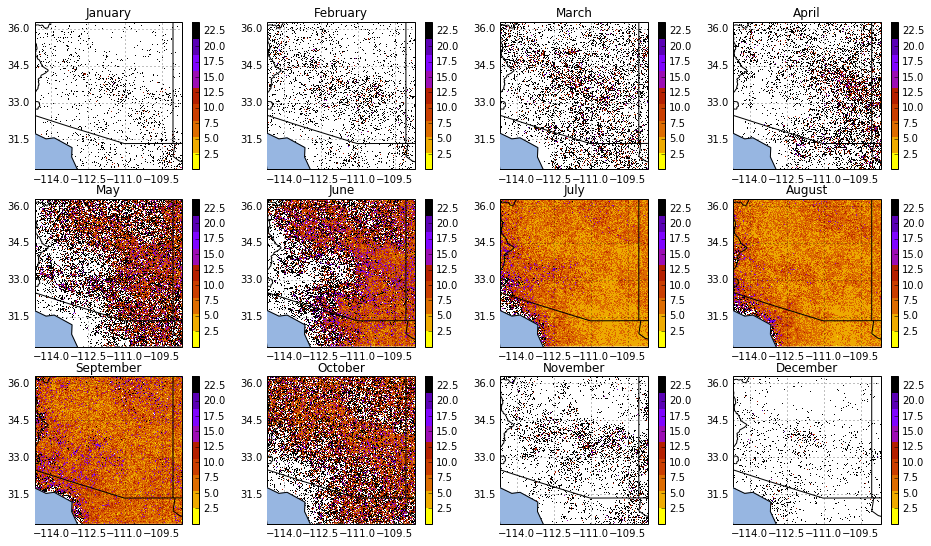

In [31]:
plt.figure(figsize=(16, 9))
for m in months.keys():
    ax = background(plt.subplot(3, 4, m, projection=ccrs.PlateCarree()))
    hourly3D = np.stack(MMDC_grid[m].values())
    amplitude = ((np.max(hourly3D, axis=0)-np.min(hourly3D, axis=0))/np.mean(hourly3D, axis=0))
    amplitude = np.nan_to_num(amplitude)
    c.plot_grid(amplitude, cmap=cmap, cbar=True, vmin=.0001, ax=ax)
    ax.set_title(months[m])

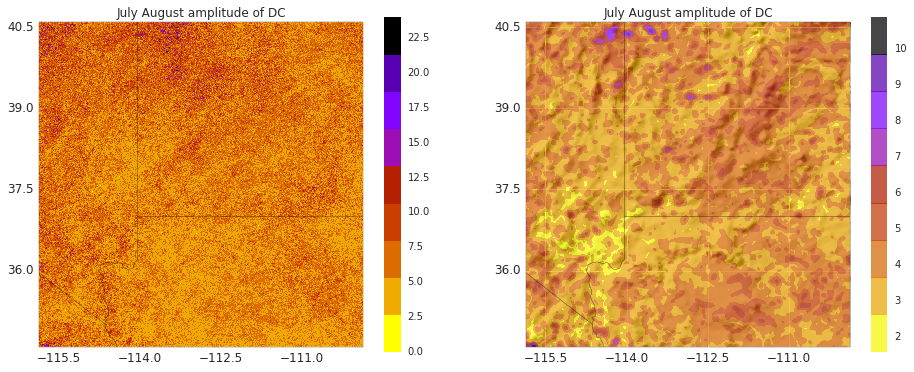

In [98]:
plt.figure(figsize=(16,6))

hourly3D = np.stack(np.stack(JADC_grid.values()))
amplitude = ((np.max(hourly3D, axis=0)-np.min(hourly3D, axis=0))/np.mean(hourly3D, axis=0))
amplitude = np.nan_to_num(amplitude)
ax = background(plt.subplot(1, 2, 1, projection=ccrs.PlateCarree()))
im, ax = c.plot_grid(amplitude, cmap=cmap, cbar=True, ax=ax, zorder=5)
ax.set_title('July August amplitude of DC');

hourly3D = np.stack(np.stack(JADC_gauss.values()))
amplitude = ((np.max(hourly3D, axis=0)-np.min(hourly3D, axis=0))/np.mean(hourly3D, axis=0))
amplitude = np.nan_to_num(amplitude)
ax = background(plt.subplot(1, 2, 2, projection=ccrs.PlateCarree()))
im, ax = c.plot_grid(amplitude, cmap=cmap, cbar=True, ax=ax, zorder=5, alpha=.7)
pre_shaded(ax)
ax.set_extent([c.gridx.min(), c.gridx.max(), c.gridy.min(), c.gridy.max()])
ax.set_title('July August amplitude of DC');

## top 100
[Top](#Regional-Climatology) | [Region](#object-orientation) | [Grid](#Grid) | [flash density](#flash-density) | [diurnal cycle](#diurnal-cycle) | [Largest 100](#top-100) | [peak](#peak-time) | [amplitude diurnal cycle](#amplitude-of-DC)

This function is kind of dirty because it uses filesize as a first pass proxy for FC. 

In [107]:
top10 = c.get_top(10)
top10

2014-09-26 12:00:00    91884
2014-09-27 12:00:00    90627
2015-08-30 12:00:00    66916
2014-08-12 12:00:00    65613
2015-07-08 12:00:00    63068
2015-07-01 12:00:00    62599
2013-08-17 12:00:00    62191
2014-08-26 12:00:00    58833
2014-07-15 12:00:00    50065
2015-08-07 12:00:00    48051
dtype: int64